# Analyze Steamboat Finisher data
- <a href='https://github.com/mbromberek/race_finisher_analyze' target='_blank'>Github page with source code for gathering data and performing analysis</a>

In 2019 the Steamboat 15K race changed from running up and down the Steamboat hills 2 times to 3 times. Want to determine if the change to the course resulted in faster or slower finisher times. 



### Table of Contents
- <a href='#finishtimes'>Comparing finish times for each year by age groups</a>
    - <a href='#finishtimes_byyear_byagegrp_all'>Finisher time for all runners by age group for each year</a>
    - <a href='#finishtimes_bycourse_byagegrp_all'>Finisher time for all runners by age group for 2 loop versus 3 loop course</a>
    - <a href='#finishtimes_byyear_byagegrp_top3'>Top 3 finishers time by age group for each year</a>
    - <a href='#finishtimes_bycourse_byagegrp_top3'>Top 3 finishers time by age group for 2 loop versus 3 loop course</a>
- <a href='#otherfactors'>Other factors that will affect finish times</a>
    - <a href='#weather'>Weather at start of race</a>
    - <a href='#number_finishers'>Number of finishers</a>


## Setup data and functions

In [1]:
# First party libraries
import os
import json

# 3rd Party Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Functions

In [2]:
def seconds_to_str(df, tm_field, format='hms'):
    df_copy = df.copy()
    df_copy['tm_sec'] = (df_copy[tm_field] %60).apply(np.floor).astype('int')

    if format == 'hms':
        df_copy['tm_hr'] = (df_copy[tm_field] / 3600).apply(np.floor).astype('int')
        df_copy['tm_min'] = ((df_copy[tm_field]-(df_copy['tm_hr']*3600)) / 60).apply(np.floor).astype('int')
        return df_copy['tm_hr'].astype('str') \
            + ':' + df_copy['tm_min'].astype('str').str.zfill(2) \
            + ':' + df_copy['tm_sec'].astype('str').str.zfill(2)
    elif format == 'ms':
        df_copy['tm_min'] = (df_copy[tm_field] / 60).apply(np.floor).astype('int')
        return df_copy['tm_min'].astype('str') + ':' + \
            df_copy['tm_sec'].astype('str').str.zfill(2)
    else:
        raise NameError('Invalid Time Output Format')


In [3]:
def get_line_graph_plot_for_years(year_list, x, df, y_field):
    line_type = '-'
    plot_lst = []
    for yr in year_list:
        if yr >='2019':
            line_type = '--'
        else:
            line_type = '-'
        plot_lst.extend([x,df[df['year']==yr][y_field], line_type])
    return plot_lst

### Race Finisher Data
- Race data pulled from Athlinks for Steamboat race for years 2016, 2017, 2018, 2019, 2021, 2022, 2023.
- There was no race in 2020 and only a 4 mile race in 2021


In [65]:
data_dir = 'data'
chart_dir = 'charts'
year_legend_dict = {'15K':['2016','2017','2018','2019','2022','2023'],'4mi':['2016','2017','2018','2019','2021','2022','2023']}
dist_mile_dict = {'15K':9.33,'4mi':4}
stat_dict = {
    'avg':{'time_chart_field':'avg_time_minute','pace_chart_field':'avg_pace_minute'\
           ,'value':'Average','id':'avg'}
    ,'median':{'time_chart_field':'median_time_minute','pace_chart_field':'median_pace_minute'\
               ,'value':'Median','id':'median'}
}
save_charts = True


In [68]:
# Filters read in race results to only ones for specified distance
f_name = 'Steamboat_clean_results.pickle'
race_results_all = pd.read_pickle(os.path.join(data_dir, f_name))
race_dist = '15K'
stat = stat_dict['avg']
year_list = year_legend_dict[race_dist]
race_results = race_results_all[race_results_all['distance'] == race_dist].copy()

### Weather Data
- Weather manually pulled from Carrot weather for 2016 through 2021
- Weather pulled from Apple WeatherKit for 2022 and 2023

In [6]:
weather_file = 'Steamboat_Weather.json'
weather_dict = {}
with open(os.path.join(data_dir, weather_file)) as json_file:
    weather_dict = json.load(json_file)


In [7]:
print(race_results.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3302 entries, 0 to 3301
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   gender        3302 non-null   object
 1   age           3302 non-null   int64 
 2   time          3302 non-null   object
 3   distance      3302 non-null   object
 4   year          3302 non-null   object
 5   time_seconds  3302 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 180.6+ KB
None


In [8]:
race_results.groupby(['year']).agg(finisher_count=('age', 'count'))

,finisher_count
year,
2016,821
2017,665
2018,655
2019,545
2022,293
2023,323


In [9]:
# Can see number of runners for 15K went down a lot after 2019
race_results.groupby(['year','gender']).agg(finisher_count=('age', 'count'))

finisher_count
year gender                
2016 F                  363
     M                  458
2017 F                  295
     M                  370
2018 F                  289
     M                  366
2019 F                  227
     M                  318
2022 F                  128
     M                  165
2023 F                  115
     M                  208

### Use Age Groups of every 5 years
- Calculate average and median finish times for age groups

In [10]:
age_group_years = 5
if age_group_years == 5:
    conditions = [
        race_results['age'].lt(20),
        race_results['age'].ge(20) & race_results['age'].lt(25),
        race_results['age'].ge(25) & race_results['age'].lt(30),
        race_results['age'].ge(30) & race_results['age'].lt(35),
        race_results['age'].ge(35) & race_results['age'].lt(40),
        race_results['age'].ge(40) & race_results['age'].lt(45),
        race_results['age'].ge(45) & race_results['age'].lt(50),
        race_results['age'].ge(50) & race_results['age'].lt(55),
        race_results['age'].ge(55) & race_results['age'].lt(60),
        race_results['age'].ge(60) & race_results['age'].lt(65),
        race_results['age'].ge(65) & race_results['age'].lt(70),
        race_results['age'].ge(70)
    ]
    choices = ['0 to 19','20 to 24','25 to 29','30 to 34','35 to 39','40 to 44','45 to 49', \
               '50 to 54','55 to 59','60 to 64','65 to 69','70 Over']
else:
    conditions = [
        race_results['age'].lt(20),
        race_results['age'].ge(20) & race_results['age'].lt(30),
        race_results['age'].ge(30) & race_results['age'].lt(40),
        race_results['age'].ge(40) & race_results['age'].lt(50),
        race_results['age'].ge(50) & race_results['age'].lt(60),
        race_results['age'].ge(60) & race_results['age'].lt(70),
        race_results['age'].ge(70)
    ]
    choices = ['0 to 19','20 to 29','30 to 39','40 to 49','50 to 59','60 to 69','70 Over']
race_results['age_group'] = np.select(conditions, choices, default=0)


In [11]:
conditions = [
    race_results['year'].isin(['2016','2017','2018']),
    race_results['year'].isin(['2019','2021','2022','2023'])
]
choices = ['2 loops','3 loops']
race_results['race_course'] = np.select(conditions, choices, default=0)

In [12]:
# The unstack, stack is used to have a record for all age groups for all years and genders
age_grp_det = race_results.groupby(['year','gender','age_group'])\
    .agg(finisher_count=('age', 'count')
         , avg_time_s = ('time_seconds','mean')
         , fastest_time_s = ('time_seconds','min')
         , slowest_time_s = ('time_seconds','max')
         , median_time_s = ('time_seconds','median')
         , std_dev_time_s = ('time_seconds', 'std')
        ).unstack(fill_value=0).stack().reset_index()

age_grp_det['avg_time_string'] = seconds_to_str(age_grp_det, 'avg_time_s')
age_grp_det['avg_time_minute'] = age_grp_det['avg_time_s'] /60
age_grp_det['median_time_string'] = seconds_to_str(age_grp_det, 'median_time_s')
age_grp_det['median_time_minute'] = age_grp_det['median_time_s'] /60
age_grp_det['std_dev_time_minute'] = age_grp_det['std_dev_time_s'] /60
age_grp_det['median_pace_s'] = age_grp_det['median_time_s'] / dist_mile_dict[race_dist]
age_grp_det['median_pace_minute'] = age_grp_det['median_pace_s'] /60
age_grp_det['median_pace_string'] = seconds_to_str(age_grp_det, 'median_pace_s', format='ms')
age_grp_det['avg_pace_s'] = age_grp_det['avg_time_s'] / dist_mile_dict[race_dist]
age_grp_det['avg_pace_minute'] = age_grp_det['avg_pace_s'] /60
age_grp_det['avg_pace_string'] = seconds_to_str(age_grp_det, 'avg_pace_s', format='ms')

# age_grp_det.info()

In [13]:
# The unstack, stack is used to have a record for all age groups for all years and genders
course_loops = race_results.groupby(['race_course','gender','age_group'])\
    .agg(finisher_count=('age', 'count')
         , avg_time_s = ('time_seconds','mean')
         , fastest_time_s = ('time_seconds','min')
         , slowest_time_s = ('time_seconds','max')
         , median_time_s = ('time_seconds','median')
         , std_dev_time_s = ('time_seconds', 'std')
        ).unstack(fill_value=0).stack().reset_index()

course_loops['avg_time_string'] = seconds_to_str(course_loops, 'avg_time_s')
course_loops['avg_time_minute'] = course_loops['avg_time_s'] /60
course_loops['median_time_string'] = seconds_to_str(course_loops, 'median_time_s')
course_loops['median_time_minute'] = course_loops['median_time_s'] /60
course_loops['std_dev_time_minute'] = course_loops['std_dev_time_s'] /60
course_loops['median_pace_s'] = course_loops['median_time_s'] / dist_mile_dict[race_dist]
course_loops['median_pace_minute'] = course_loops['median_pace_s'] /60
course_loops['median_pace_string'] = seconds_to_str(course_loops, 'median_pace_s', format='ms')
course_loops['avg_pace_s'] = course_loops['avg_time_s'] / dist_mile_dict[race_dist]
course_loops['avg_pace_minute'] = course_loops['avg_pace_s'] /60
course_loops['avg_pace_string'] = seconds_to_str(course_loops, 'avg_pace_s', format='ms')

# course_loops.info()
# course_loops[['gender','age_group','median_time_s','median_pace_s','median_time_minute','median_pace_minute']]

In [14]:
age_grp_men = age_grp_det[age_grp_det['gender'] =='M'].reset_index().\
    drop(columns=['index','gender'])
age_grp_women = age_grp_det[age_grp_det['gender'] =='F'].reset_index().\
    drop(columns=['index','gender'])


<a id='finishtimes'></a>
# Comparing Finish Times for each year by age groups
- <a href='#finishtimes_byyear_byagegrp_all'>Median finishing time by age groups for each year</a>
- <a href='#finishtimes_bycourse_byagegrp_all'>Median finishing time by age groups for 3 years of 2 hill loop course and 3 years of 3 hill loop course</a>
- <a href='#finishtimes_byyear_byagegrp_top3'>Median finishing time for top 3 of each age groups for each year</a>
- <a href='#finishtimes_bycourse_byagegrp_top3'>Median finishing time for top 3 of each age groups for 3 years of 2 hill loop course and 3 years of 3 hill loop course</a>

In [15]:
age_grp_det[(age_grp_det['year']=='2018') & (age_grp_det['gender'] == 'M')]\
    [['year','gender','age_group','finisher_count',\
      'median_time_string','median_pace_string','avg_pace_string'
     ]]

,year,gender,age_group,finisher_count,median_time_string,median_pace_string,avg_pace_string
60,2018,M,0 to 19,17,1:09:44,7:28,7:23
61,2018,M,20 to 24,24,1:13:39,7:53,8:19
62,2018,M,25 to 29,38,1:26:31,9:16,9:14
63,2018,M,30 to 34,52,1:23:16,8:55,9:35
64,2018,M,35 to 39,66,1:24:27,9:03,9:15
65,2018,M,40 to 44,35,1:22:32,8:50,9:11
66,2018,M,45 to 49,41,1:27:22,9:21,9:24
67,2018,M,50 to 54,35,1:28:32,9:29,9:42
68,2018,M,55 to 59,26,1:31:49,9:50,10:23
69,2018,M,60 to 64,20,1:36:59,10:23,10:16


In [16]:
age_grp_det[(age_grp_det['year']=='2023') & (age_grp_det['gender'] == 'M')]\
    [['year','gender','age_group','finisher_count','avg_time_minute','median_time_minute',\
     'std_dev_time_minute']]

,year,gender,age_group,finisher_count,avg_time_minute,median_time_minute,std_dev_time_minute
132,2023,M,0 to 19,10,64.733333,56.616667,17.348275
133,2023,M,20 to 24,22,58.427273,52.466667,11.716602
134,2023,M,25 to 29,18,82.766667,85.908333,12.484032
135,2023,M,30 to 34,31,81.568817,84.483333,14.490890
136,2023,M,35 to 39,32,80.820833,79.766667,12.925981
137,2023,M,40 to 44,28,85.912500,81.641667,16.649006
138,2023,M,45 to 49,26,84.147436,83.550000,14.959994
139,2023,M,50 to 54,17,83.108824,82.033333,7.667315
140,2023,M,55 to 59,8,86.922917,83.375000,14.323654
141,2023,M,60 to 64,10,83.978333,83.791667,5.417598


<a id='finishtimes_byyear_byagegrp_all'></a>
## Comparing median finish times by age group for each year
- dashed lines are for 3 loop course

Viewing each individual race can be hard to tell if finishers averaged faster or slower times based on the course change. 

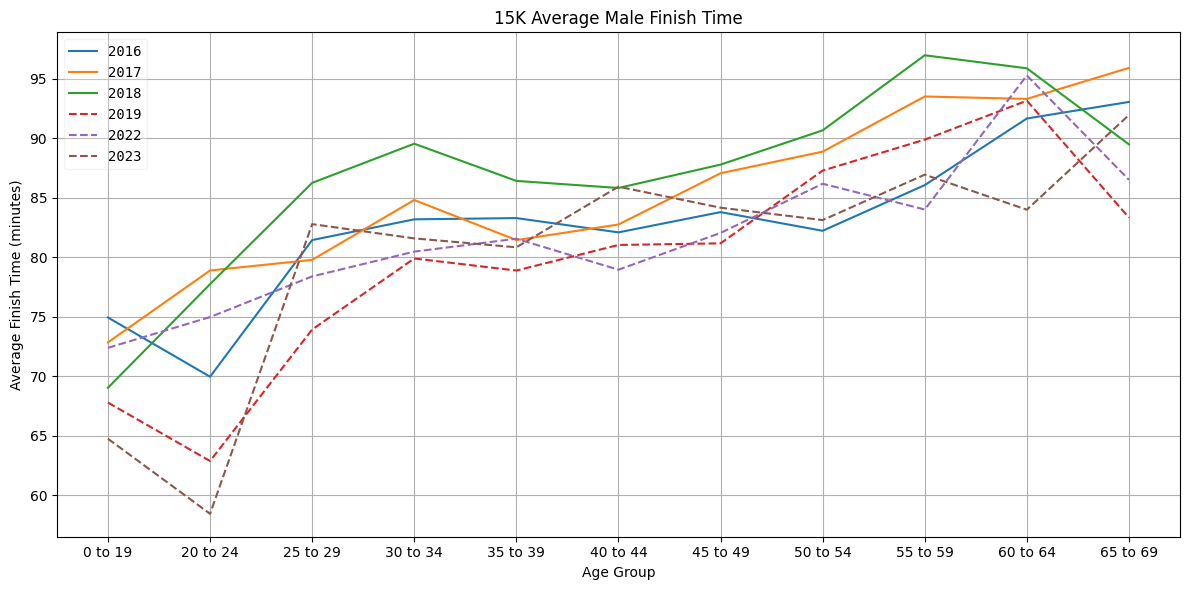

In [17]:
# Remove 70 Over group to make the fastest and slowest time range smaller
gender_grp = age_grp_men[age_grp_men['age_group'] != '70 Over'].copy()

x = gender_grp['age_group'].unique()
plots = plt.plot(*get_line_graph_plot_for_years(year_list, x, gender_grp, stat['time_chart_field']))
plt.legend(plots, (year_list), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' '+stat['value'] + ' Male Finish Time')
plt.xlabel('Age Group')
plt.ylabel(stat['value']+' Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
if save_charts:
    plt.savefig(os.path.join(chart_dir, race_dist+'_'+stat['value']+'_male_finisher_times_5yr_age_goups.png'), dpi=200)

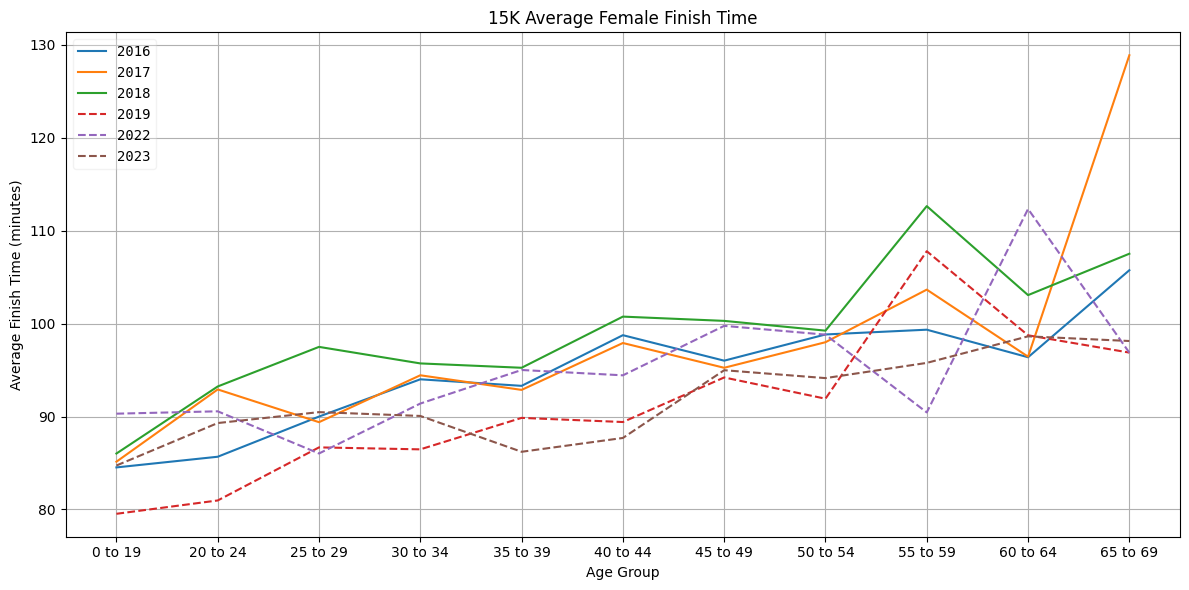

In [45]:
# Remove 70 Over group to make the fastest and slowest time range smaller
gender_grp = age_grp_women[age_grp_women['age_group'] != '70 Over']

x = gender_grp['age_group'].unique()
plots = plt.plot(*get_line_graph_plot_for_years(year_list, x, gender_grp, stat['time_chart_field']))
plt.legend(plots, (year_list), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' '+stat['value'] + ' Female Finish Time')
plt.xlabel('Age Group')
plt.ylabel(stat['value']+' Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
if save_charts:
    plt.savefig(os.path.join(chart_dir, race_dist+'_'+stat['value']+'_female_finisher_times_5yr_age_goups.png'), dpi=200)

<a id='finishtimes_bycourse_byagegrp_all'></a>
## Comparing median finish times for 2 versus 3 times up Steamboat Hill
Combine finishing times for 2016 through 2018 into “2 loop course” and 2019, 2022, and 2023 into “3 loop course” and get the median for those groups.

Can see the mens finishing times are always faster with the 3 loop course and the 3 loop course is usually faster for women. 

This indicates the new course is faster despite going up the Steamboat Hill 3 times instead of 2 times. 

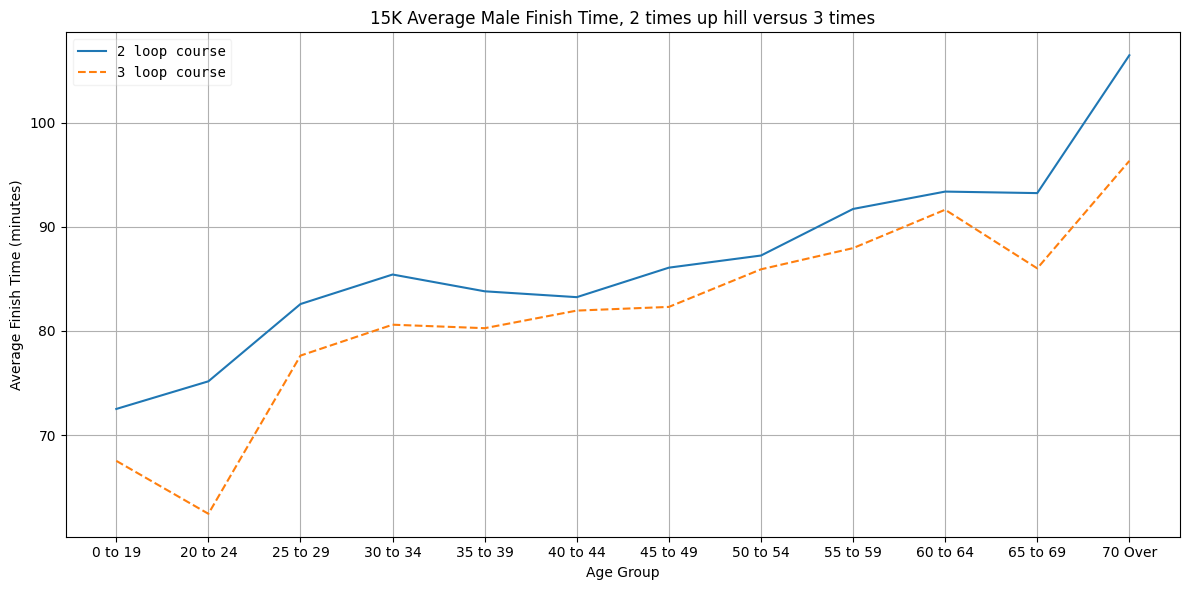

In [46]:
gender_grp = course_loops[course_loops['gender']=='M'].copy()
x = gender_grp['age_group'].unique()
plots = plt.plot(x,gender_grp[gender_grp['race_course']=='2 loops'][stat['time_chart_field']], '-', 
                 x,gender_grp[gender_grp['race_course']=='3 loops'][stat['time_chart_field']], '--'
                )
plt.legend(plots, ('2 loop course','3 loop course'), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' '+stat['value'] + ' Male Finish Time, 2 times up hill versus 3 times')
plt.xlabel('Age Group')
plt.ylabel(stat['value']+' Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
if save_charts:
    plt.savefig(os.path.join(chart_dir, race_dist+'_'+stat['value']+'_male_finisher_times_5yr_age_goups_2_vs_3_loops.png'), dpi=200)

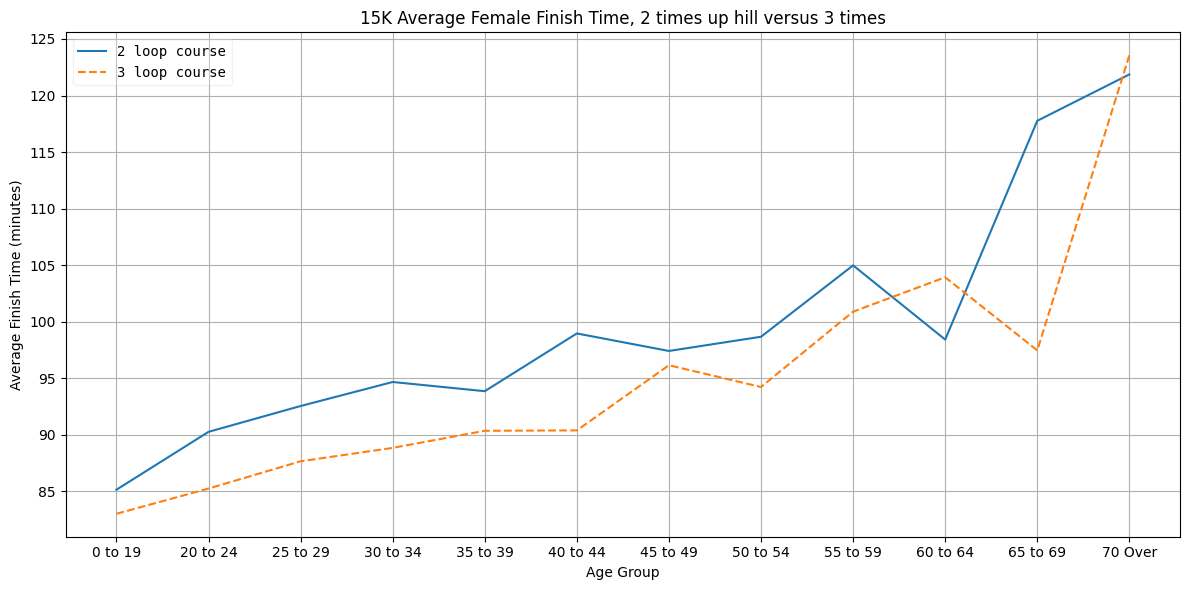

In [47]:
gender_grp = course_loops[course_loops['gender']=='F'].copy()
x = gender_grp['age_group'].unique()
plots = plt.plot(x,gender_grp[gender_grp['race_course']=='2 loops'][stat['time_chart_field']], '-', 
                 x,gender_grp[gender_grp['race_course']=='3 loops'][stat['time_chart_field']], '--'
                )
plt.legend(plots, ('2 loop course','3 loop course'), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' '+stat['value'] + ' Female Finish Time, 2 times up hill versus 3 times')
plt.xlabel('Age Group')
plt.ylabel(stat['value']+' Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
if save_charts:
    plt.savefig(os.path.join(chart_dir, race_dist+'_'+stat['value']+'_female_finisher_times_5yr_age_goups_2_vs_3_loops.png'), dpi=200)

Comparing the median pace in minutes per mile for the 2 loop versus 3 loop course

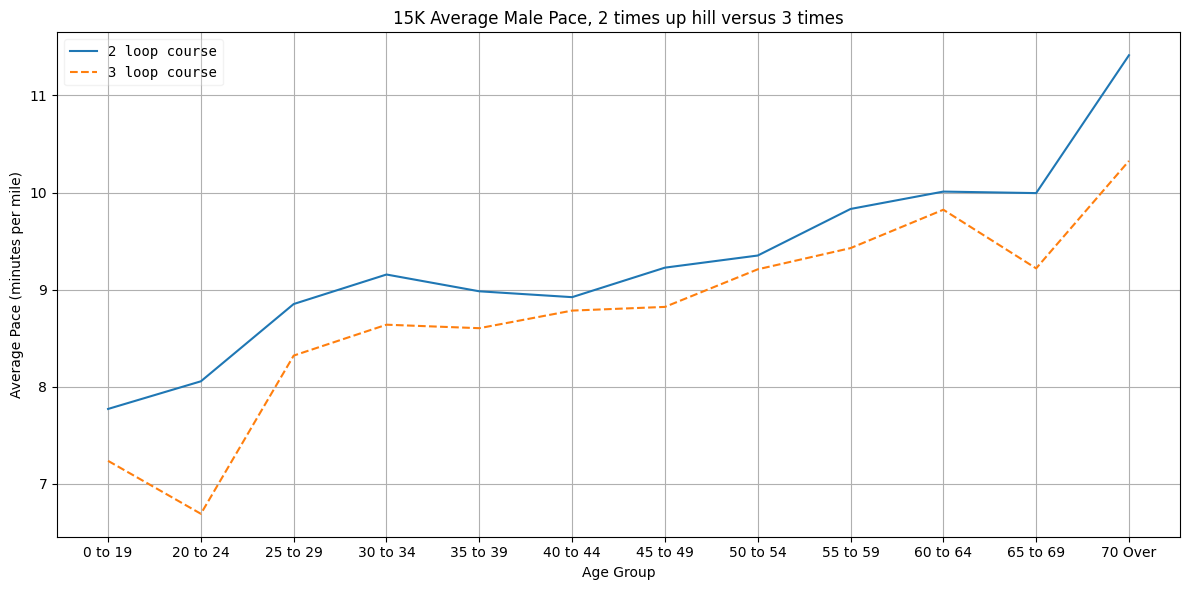

In [48]:
gender_grp = course_loops[course_loops['gender']=='M'].copy()
x = gender_grp['age_group'].unique()
plots = plt.plot(x,gender_grp[gender_grp['race_course']=='2 loops'][stat['pace_chart_field']], '-', 
                 x,gender_grp[gender_grp['race_course']=='3 loops'][stat['pace_chart_field']], '--'
                )
plt.legend(plots, ('2 loop course','3 loop course'), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' '+stat['value'] + ' Male Pace, 2 times up hill versus 3 times')
plt.xlabel('Age Group')
plt.ylabel(stat['value']+' Pace (minutes per mile)')
plt.grid(True)
plt.tight_layout()

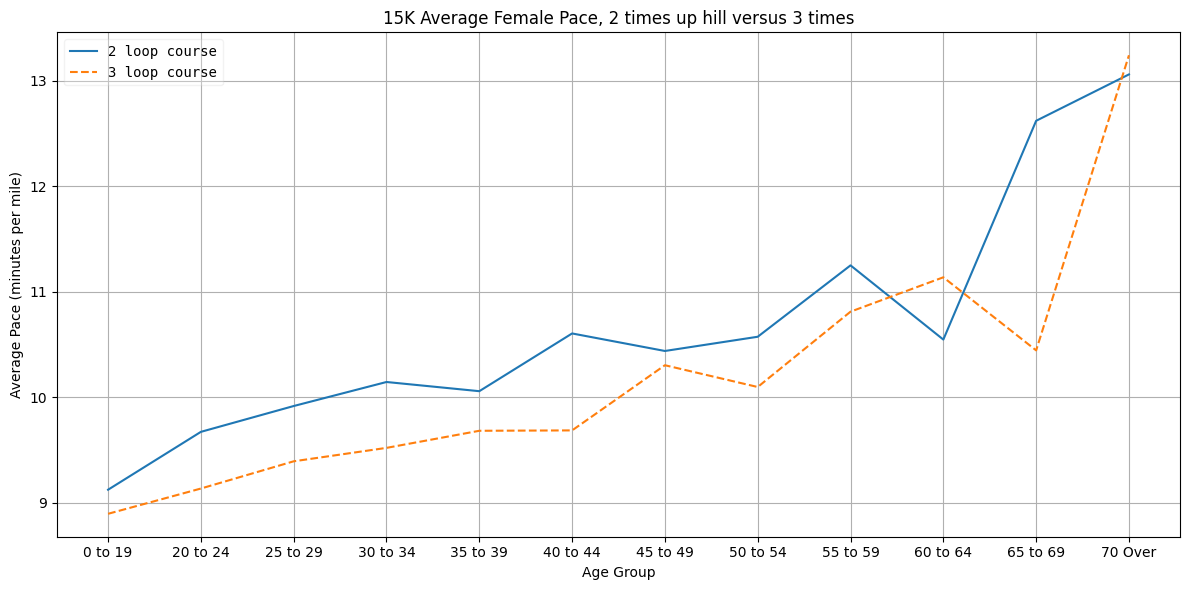

In [49]:
gender_grp = course_loops[course_loops['gender']=='F'].copy()
x = gender_grp['age_group'].unique()
plots = plt.plot(x,gender_grp[gender_grp['race_course']=='2 loops'][stat['pace_chart_field']], '-', 
                 x,gender_grp[gender_grp['race_course']=='3 loops'][stat['pace_chart_field']], '--'
                )
plt.legend(plots, ('2 loop course','3 loop course'), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' '+stat['value'] + ' Female Pace, 2 times up hill versus 3 times')
plt.xlabel('Age Group')
plt.ylabel(stat['value']+' Pace (minutes per mile)')
plt.grid(True)
plt.tight_layout()

### Difference in Median time between 3 loop and 2 courses

In [77]:
# import tabulate 
loops_2 = course_loops[(course_loops['race_course'] == '2 loops') & (course_loops['gender'].isin(['M','F']))]
loops_3 = course_loops[(course_loops['race_course'] == '3 loops') & (course_loops['gender'].isin(['M','F']))]
loop_result = loops_2.merge(loops_3, how='outer', on=['gender','age_group'])
loop_result.fillna(0,inplace=True)

# print(loop_result.info())
# Get difference for time
if stat['id'] == 'median':
    loop_result['diff_finish_time_s'] = (loop_result['median_time_s_y'] - \
        loop_result['median_time_s_x']).abs()
    loop_result['3 loop faster'] = loop_result['median_time_s_y'] < loop_result['median_time_s_x']
    loop_result['diff_pace_s'] = (loop_result['median_pace_s_y'] - \
        loop_result['median_pace_s_x']).abs()
    loop_result['diff_pace_s_abs'] = loop_result['diff_pace_s'].abs()
else:
    loop_result['diff_finish_time_s'] = (loop_result['avg_time_s_y'] - \
        loop_result['avg_time_s_x']).abs()
    loop_result['3 loop faster'] = loop_result['avg_time_s_y'] < loop_result['avg_time_s_x']
    loop_result['diff_pace_s'] = (loop_result['avg_pace_s_y'] - \
        loop_result['avg_pace_s_x']).abs()
    loop_result['diff_pace_s_abs'] = loop_result['diff_pace_s'].abs()
    
loop_result['Difference Time'] = seconds_to_str(loop_result,'diff_finish_time_s', format='ms')

loop_result['Time Delta'] = \
    loop_result['Difference Time'] + np.where(loop_result['3 loop faster'], ' faster', ' slower')
loop_result['Pace Delta'] = \
    seconds_to_str(loop_result,'diff_pace_s_abs', format='ms') \
    + '/mile' \
    + np.where(loop_result['3 loop faster'], ' faster', ' slower')

loop_result.rename(columns={\
    'gender':'Gender','age_group':'Age Group',
    'finisher_count_x':'2 loop Finishers','median_time_minute_x':'2 loop Median Time Minutes',\
    'avg_time_minute_x':'2 loop Average Time Minutes',\
    'finisher_count_y':'3 loop Finishers','median_time_minute_y':'3 loop Median Time Minutes',\
    'avg_time_minute_y':'3 loop Average Time Minutes',
    }, inplace=True
)
if stat['id'] == 'median':
    loop_result.rename(columns={\
        'median_time_string_x':'2 Loop','median_time_string_y':'3 Loop'
        }, inplace=True
    )
else:
    loop_result.rename(columns={\
        'avg_time_string_x':'2 Loop','avg_time_string_y':'3 Loop'
        }, inplace=True
    )
# loop_result.drop(columns=['race_course_x','avg_time_s_x','fastest_time_s_x','slowest_time_s_x'\
#                           ,'median_time_s_x','std_dev_time_s_x','avg_time_string_x'\
#                           ,'race_course_y','avg_time_s_y','fastest_time_s_y','slowest_time_s_y'\
#                           ,'median_time_s_y','std_dev_time_s_y','avg_time_string_y'
#                           ], inplace=True)
# print(loop_result[['Gender','Age Group'\
#              # , '2 loop Finishers','3 loop Finishers'\
#              , '2 Loop Time','3 Loop Time'\
#              # ,'2 loop Median Time Minutes','3 loop Median Time Minutes'\
#              # , 'diff_median_finish_time_s','3 loop faster','Time Difference'\
#              , 'Difference 3 loop versus 2'
#              ]]\
#     .sort_values(['Gender','Age Group']).to_string(index=False))


# print(tabulate.tabulate(loop_result[['Gender','Age Group'\
#              # , '2 loop Finishers','3 loop Finishers'\
#              , '2 Loop Time','3 Loop Time'\
#              # ,'2 loop Median Time Minutes','3 loop Median Time Minutes'\
#              # , 'diff_median_finish_time_s','3 loop faster','Time Difference'\
#              , 'Difference 3 loop versus 2'\
#              ]]\
#     .sort_values(['Gender','Age Group']), headers='keys',tablefmt='psql'))

display(loop_result[['Gender','Age Group'\
             , '2 Loop','3 Loop'\
             , 'Time Delta', 'Pace Delta'
             ]]\
    .sort_values(['Gender','Age Group']))


,Gender,Age Group,2 Loop,3 Loop,Time Delta,Pace Delta
0,F,0 to 19,1:25:07,1:22:59,2:07 faster,0:13/mile faster
1,F,20 to 24,1:30:14,1:25:13,5:00 faster,0:32/mile faster
2,F,25 to 29,1:32:31,1:27:37,4:53 faster,0:31/mile faster
3,F,30 to 34,1:34:38,1:28:49,5:49 faster,0:37/mile faster
4,F,35 to 39,1:33:50,1:30:19,3:30 faster,0:22/mile faster
5,F,40 to 44,1:38:56,1:30:22,8:34 faster,0:55/mile faster
6,F,45 to 49,1:37:23,1:36:08,1:15 faster,0:08/mile faster
7,F,50 to 54,1:38:39,1:34:12,4:26 faster,0:28/mile faster
8,F,55 to 59,1:44:58,1:40:52,4:05 faster,0:26/mile faster
9,F,60 to 64,1:38:24,1:43:54,5:30 slower,0:35/mile slower


The Median Age Group pace change for 2 loop versus 3 for males and females

In [74]:

# The unstack, stack is used to have a record for all age groups for all years and genders

if stat['id'] == 'median':
    pace_df = loop_result.groupby(['Gender'])\
        .agg(pace_s=('diff_pace_s', 'median')
            ).reset_index()
else:
    pace_df = loop_result.groupby(['Gender'])\
        .agg(pace_s=('diff_pace_s', 'mean')
            ).reset_index()
pace_df[stat['value']+' Pace Delta'] = seconds_to_str(pace_df, 'pace_s', format='ms') + '/mile'
display(pace_df[['Gender',stat['value']+' Pace Delta']])

,Gender,Average Pace Delta
0,F,0:29/mile
1,M,0:17/mile


<a id='finishtimes_byyear_byagegrp_top3'></a>

<a id='finishtimes_byyear_byagegrp_top3'></a>
## Finish times of top three by age group for each year
Using the top 3 finishers for each age group the median finish time for men and women is much closer indicating the top 3 finisher for each age group was not significantly impacted by the course change. 

In [25]:
race_results['age_grp_place'] = race_results.groupby(['year','gender','age_group']).cumcount()
age_grp_top3 = race_results[race_results['age_grp_place'] <3]

In [60]:
# The unstack, stack is used to have a record for all age groups for all years and genders
age_grp_det_top3 = age_grp_top3.groupby(['year','gender','age_group'])\
    .agg(finisher_count=('age', 'count')
         , avg_time_s = ('time_seconds','mean')
         , fastest_time_s = ('time_seconds','min')
         , slowest_time_s = ('time_seconds','max')
         , median_time_s = ('time_seconds','median')
         , std_dev_time_s = ('time_seconds', 'std')
        ).unstack(fill_value=0).stack().reset_index()

age_grp_det_top3['avg_time_string'] = seconds_to_str(age_grp_det_top3, 'avg_time_s')
age_grp_det_top3['avg_time_minute'] = age_grp_det_top3['avg_time_s'] /60
age_grp_det_top3['median_time_string'] = seconds_to_str(age_grp_det_top3, 'median_time_s')
age_grp_det_top3['median_time_minute'] = age_grp_det_top3['median_time_s'] /60
age_grp_det_top3['std_dev_time_minute'] = age_grp_det_top3['std_dev_time_s'] /60
age_grp_det_top3['median_pace_s'] = age_grp_det_top3['median_time_s'] / dist_mile_dict[race_dist]
age_grp_det_top3['median_pace_minute'] = age_grp_det_top3['median_pace_s'] /60
age_grp_det_top3['median_pace_string'] = seconds_to_str(age_grp_det_top3, 'median_pace_s', format='ms')
age_grp_det_top3['avg_pace_s'] = age_grp_det_top3['avg_time_s'] / dist_mile_dict[race_dist]
age_grp_det_top3['avg_pace_minute'] = age_grp_det_top3['avg_pace_s'] /60
age_grp_det_top3['avg_pace_string'] = seconds_to_str(age_grp_det_top3, 'avg_pace_s', format='ms')

# age_grp_det_top3.info()

In [61]:
# The unstack, stack is used to have a record for all age groups for all years and genders
course_loops_top3 = age_grp_top3.groupby(['race_course','gender','age_group'])\
    .agg(finisher_count=('age', 'count')
         , avg_time_s = ('time_seconds','mean')
         , fastest_time_s = ('time_seconds','min')
         , slowest_time_s = ('time_seconds','max')
         , median_time_s = ('time_seconds','median')
         , std_dev_time_s = ('time_seconds', 'std')
        ).unstack(fill_value=0).stack().reset_index()

course_loops_top3['avg_time_string'] = seconds_to_str(course_loops_top3, 'avg_time_s')
course_loops_top3['avg_time_minute'] = course_loops_top3['avg_time_s'] /60
course_loops_top3['median_time_string'] = seconds_to_str(course_loops_top3, 'median_time_s')
course_loops_top3['median_time_minute'] = course_loops_top3['median_time_s'] /60
course_loops_top3['std_dev_time_minute'] = course_loops_top3['std_dev_time_s'] /60
course_loops_top3['median_pace_s'] = course_loops_top3['median_time_s'] / dist_mile_dict[race_dist]
course_loops_top3['median_pace_minute'] = course_loops_top3['median_pace_s'] /60
course_loops_top3['median_pace_string'] = seconds_to_str(course_loops_top3, 'median_pace_s', format='ms')
course_loops_top3['avg_pace_s'] = course_loops_top3['avg_time_s'] / dist_mile_dict[race_dist]
course_loops_top3['avg_pace_minute'] = course_loops_top3['avg_pace_s'] /60
course_loops_top3['avg_pace_string'] = seconds_to_str(course_loops_top3, 'avg_pace_s', format='ms')

# course_loops_top3.info()


In [28]:
age_grp_det_top3.head(20)

,year,gender,age_group,finisher_count,avg_time_s,fastest_time_s,slowest_time_s,median_time_s,std_dev_time_s,avg_time_string,avg_time_minute,median_time_string,median_time_minute,std_dev_time_minute,median_pace_s,median_pace_minute,median_pace_string
0,2016,F,0 to 19,3,3947.000000,3654,4231,3956.0,288.605267,1:05:47,65.783333,1:05:56,65.933333,4.810088,424.008574,7.066810,7:04
1,2016,F,20 to 24,3,4010.333333,3985,4026,4020.0,22.143472,1:06:50,66.838889,1:07:00,67.000000,0.369058,430.868167,7.181136,7:10
2,2016,F,25 to 29,3,4203.333333,4131,4292,4187.0,81.733306,1:10:03,70.055556,1:09:47,69.783333,1.362222,448.767417,7.479457,7:28
3,2016,F,30 to 34,3,3797.666667,3537,4058,3798.0,260.500160,1:03:17,63.294444,1:03:18,63.300000,4.341669,407.073955,6.784566,6:47
4,2016,F,35 to 39,3,4256.666667,4220,4310,4240.0,47.258156,1:10:56,70.944444,1:10:40,70.666667,0.787636,454.448017,7.574134,7:34
5,2016,F,40 to 44,3,4051.000000,3969,4158,4026.0,96.948440,1:07:31,67.516667,1:07:06,67.100000,1.615807,431.511254,7.191854,7:11
6,2016,F,45 to 49,3,4699.000000,4587,4780,4730.0,100.164864,1:18:19,78.316667,1:18:50,78.833333,1.669414,506.966774,8.449446,8:26
7,2016,F,50 to 54,3,4591.666667,4328,4755,4692.0,230.504519,1:16:31,76.527778,1:18:12,78.200000,3.841742,502.893891,8.381565,8:22
8,2016,F,55 to 59,3,4975.000000,4858,5134,4933.0,142.712999,1:22:55,82.916667,1:22:13,82.216667,2.378550,528.724544,8.812076,8:48
9,2016,F,60 to 64,3,4863.666667,4814,4904,4873.0,45.720163,1:21:03,81.061111,1:21:13,81.216667,0.762003,522.293676,8.704895,8:42


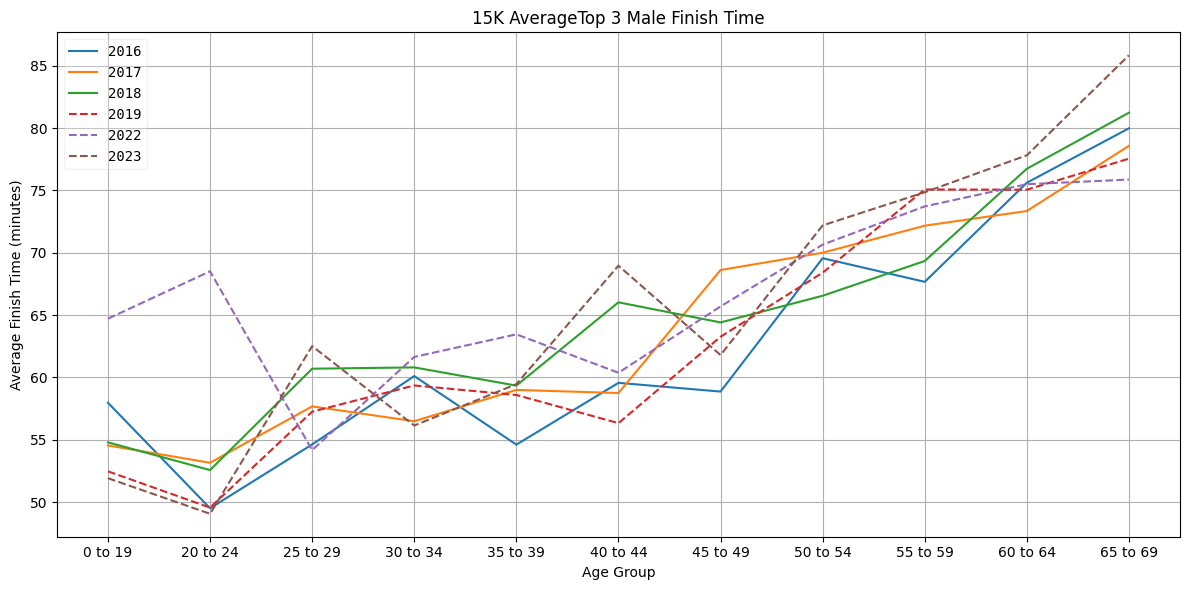

In [51]:
# Remove 70 Over group to make the fastest and slowest time range smaller
gender_grp = age_grp_det_top3[(age_grp_det_top3['gender'] == 'M') & (age_grp_det_top3['age_group'] != '70 Over')].copy()

x = gender_grp['age_group'].unique()
plots = plt.plot(*get_line_graph_plot_for_years(year_list, x, gender_grp, stat['time_chart_field']))
plt.legend(plots, (year_list), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' '+stat['value'] + 'Top 3 Male Finish Time')
plt.xlabel('Age Group')
plt.ylabel(stat['value']+' Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
if save_charts:
    plt.savefig(os.path.join(chart_dir, race_dist+'_'+stat['value']+'_male_finisher_times_5yr_age_goups_top3.png'), dpi=200)

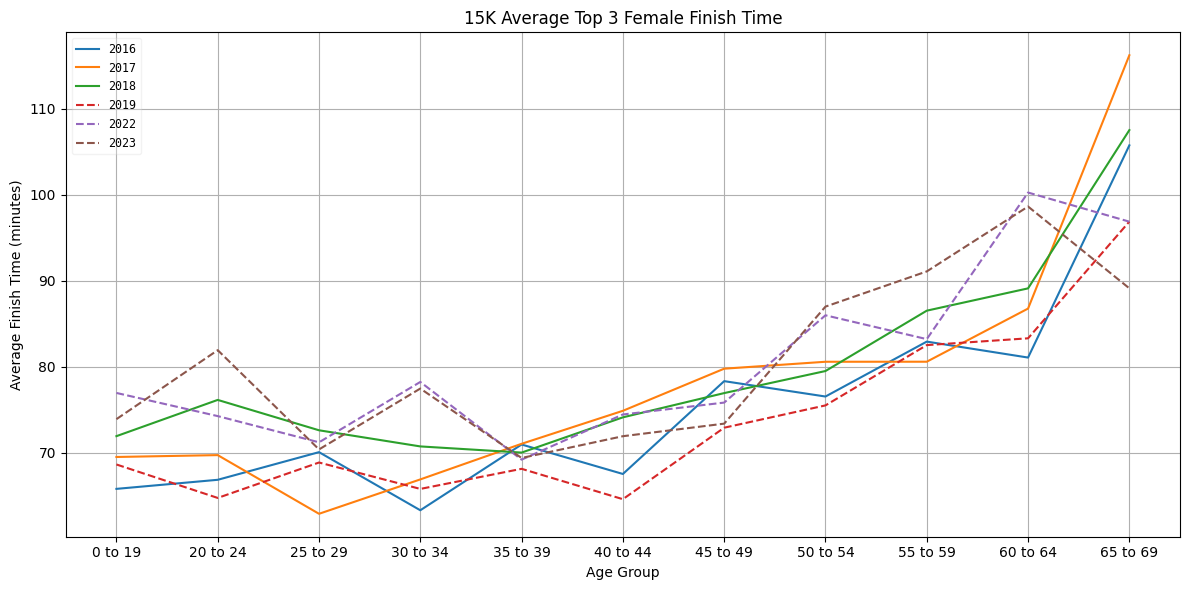

In [52]:
# Remove 70 Over group to make the fastest and slowest time range smaller
gender_grp = age_grp_det_top3[(age_grp_det_top3['gender'] == 'F') & (age_grp_det_top3['age_group'] != '70 Over')].copy()
x = gender_grp['age_group'].unique()

plots = plt.plot(*get_line_graph_plot_for_years(year_list, x, gender_grp, stat['time_chart_field']))
plt.legend(plots, (year_list), loc='best', 
           framealpha=0.25, prop={'size':'small', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' '+stat['value'] + ' Top 3 Female Finish Time')
plt.xlabel('Age Group')
plt.ylabel(stat['value']+' Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
if save_charts:
    plt.savefig(os.path.join(chart_dir, race_dist+'_'+stat['value']+'_female_finisher_times_5yr_age_goups_top3.png'), dpi=200)

<a id='finishtimes_bycourse_byagegrp_top3'></a>
## Top three by age group for 2 versus 3 times up Steamboat Hill
Do not see much difference in age groups when grouping the races by the different course layouts. 

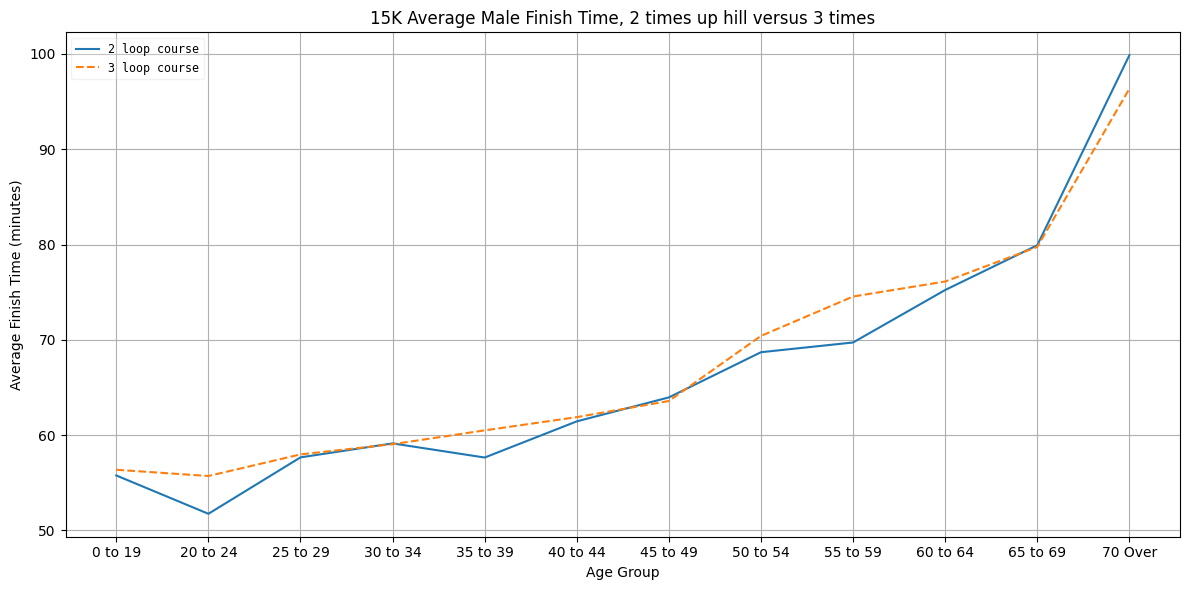

In [53]:
gender_grp = course_loops_top3[course_loops_top3['gender']=='M'].copy()
x = gender_grp['age_group'].unique()
plots = plt.plot(x,gender_grp[gender_grp['race_course']=='2 loops'][stat['time_chart_field']], '-', 
                 x,gender_grp[gender_grp['race_course']=='3 loops'][stat['time_chart_field']], '--'
                )
plt.legend(plots, ('2 loop course','3 loop course'), loc='best', 
           framealpha=0.25, prop={'size':'small', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' '+stat['value'] + ' Male Finish Time, 2 times up hill versus 3 times')
plt.xlabel('Age Group')
plt.ylabel(stat['value']+' Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
if save_charts:
    plt.savefig(os.path.join(chart_dir, race_dist+'_'+stat['value']+'_male_finisher_times_5yr_age_goups_2_vs_3_loops_top3.png'), dpi=200)

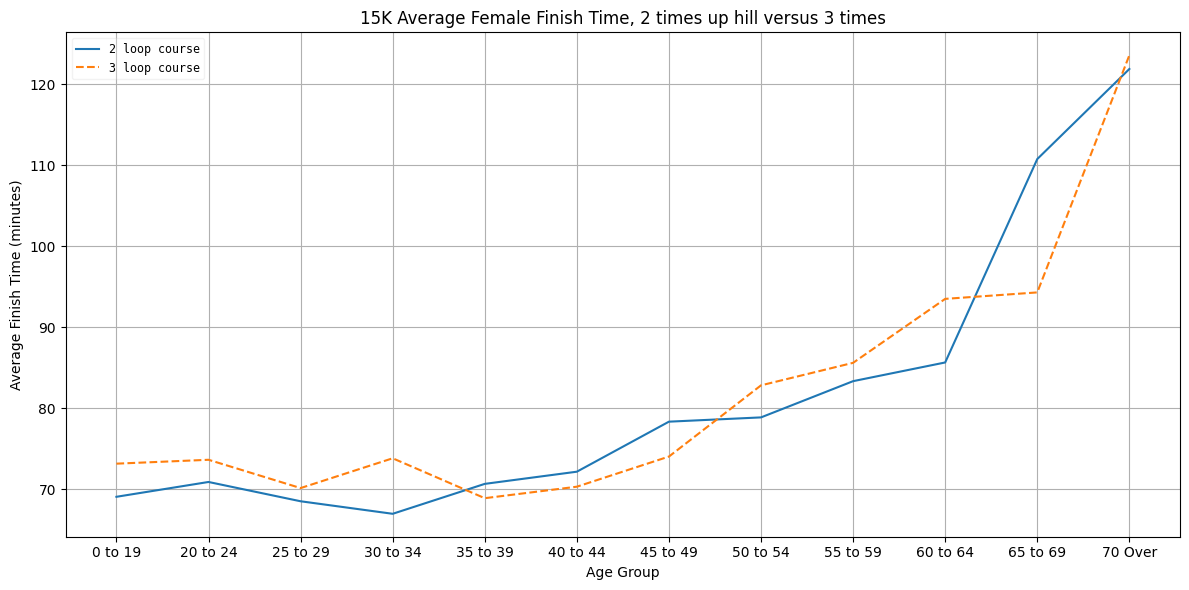

In [54]:
gender_grp = course_loops_top3[course_loops_top3['gender']=='F'].copy()
x = gender_grp['age_group'].unique()
plots = plt.plot(x,gender_grp[gender_grp['race_course']=='2 loops'][stat['time_chart_field']], '-', 
                 x,gender_grp[gender_grp['race_course']=='3 loops'][stat['time_chart_field']], '--'
                )
plt.legend(plots, ('2 loop course','3 loop course'), loc='best', 
           framealpha=0.25, prop={'size':'small', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' '+stat['value'] + ' Female Finish Time, 2 times up hill versus 3 times')
plt.xlabel('Age Group')
plt.ylabel(stat['value']+' Finish Time (minutes)')
plt.grid(True)
plt.tight_layout()
if save_charts:
    plt.savefig(os.path.join(chart_dir, race_dist+'_'+stat['value']+'_female_finisher_times_5yr_age_goups_2_vs_3_loops_top3.png'), dpi=200)

In [80]:
loops_2 = course_loops_top3[(course_loops_top3['race_course'] == '2 loops') \
    & (course_loops_top3['gender'].isin(['M','F']))]
loops_3 = course_loops_top3[(course_loops_top3['race_course'] == '3 loops') \
    & (course_loops_top3['gender'].isin(['M','F']))]
loop_result = loops_2.merge(loops_3, how='outer', on=['gender','age_group'])
loop_result.fillna(0,inplace=True)

# Get difference for time
if stat['id'] == 'median':
    loop_result['diff_finish_time_s'] = (loop_result['median_time_s_y'] - \
        loop_result['median_time_s_x']).abs()
    loop_result['3 loop faster'] = loop_result['median_time_s_y'] < loop_result['median_time_s_x']
    loop_result['diff_pace_s'] = (loop_result['median_pace_s_y'] - \
        loop_result['median_pace_s_x']).abs()
    loop_result['diff_pace_s_abs'] = loop_result['diff_pace_s'].abs()
else:
    loop_result['diff_finish_time_s'] = (loop_result['avg_time_s_y'] - \
        loop_result['avg_time_s_x']).abs()
    loop_result['3 loop faster'] = loop_result['avg_time_s_y'] < loop_result['avg_time_s_x']
    loop_result['diff_pace_s'] = (loop_result['avg_pace_s_y'] - \
        loop_result['avg_pace_s_x']).abs()
    loop_result['diff_pace_s_abs'] = loop_result['diff_pace_s'].abs()
    
loop_result['Difference Time'] = seconds_to_str(loop_result,'diff_finish_time_s', format='ms')

loop_result['Time Delta'] = \
    loop_result['Difference Time'] + np.where(loop_result['3 loop faster'], ' faster', ' slower')
loop_result['Pace Delta'] = \
    seconds_to_str(loop_result,'diff_pace_s_abs', format='ms') \
    + '/mile' \
    + np.where(loop_result['3 loop faster'], ' faster', ' slower')

loop_result.rename(columns={\
    'gender':'Gender','age_group':'Age Group',
    'finisher_count_x':'2 loop Finishers','median_time_minute_x':'2 loop Median Time Minutes',\
    'avg_time_minute_x':'2 loop Average Time Minutes',\
    'finisher_count_y':'3 loop Finishers','median_time_minute_y':'3 loop Median Time Minutes',\
    'avg_time_minute_y':'3 loop Average Time Minutes',
    }, inplace=True
)
if stat['id'] == 'median':
    loop_result.rename(columns={\
        'median_time_string_x':'2 Loop','median_time_string_y':'3 Loop'
        }, inplace=True
    )
else:
    loop_result.rename(columns={\
        'avg_time_string_x':'2 Loop','avg_time_string_y':'3 Loop'
        }, inplace=True
    )

display(loop_result[['Gender','Age Group'\
             , '2 Loop','3 Loop'\
             , 'Time Delta', 'Pace Delta'
             ]]\
    .sort_values(['Gender','Age Group']))


,Gender,Age Group,2 Loop,3 Loop,Time Delta,Pace Delta
0,F,0 to 19,1:09:03,1:13:09,4:05 slower,0:26/mile slower
1,F,20 to 24,1:10:53,1:13:38,2:44 slower,0:17/mile slower
2,F,25 to 29,1:08:30,1:10:08,1:37 slower,0:10/mile slower
3,F,30 to 34,1:06:58,1:13:49,6:51 slower,0:44/mile slower
4,F,35 to 39,1:10:39,1:08:53,1:46 faster,0:11/mile faster
5,F,40 to 44,1:12:09,1:10:18,1:51 faster,0:11/mile faster
6,F,45 to 49,1:18:20,1:14:01,4:18 faster,0:27/mile faster
7,F,50 to 54,1:18:51,1:22:49,3:57 slower,0:25/mile slower
8,F,55 to 59,1:23:20,1:25:36,2:15 slower,0:14/mile slower
9,F,60 to 64,1:25:38,1:33:29,7:50 slower,0:50/mile slower


The Median Age Group pace change for 2 loop versus 3 for males and females

In [82]:
if stat['id'] == 'median':
    pace_df = loop_result.groupby(['Gender'])\
        .agg(pace_s=('diff_pace_s', 'median')
            ).reset_index()
else:
    pace_df = loop_result.groupby(['Gender'])\
        .agg(pace_s=('diff_pace_s', 'mean')
            ).reset_index()
pace_df[stat['value']+' Pace Delta'] = seconds_to_str(pace_df, 'pace_s', format='ms') + '/mile'
display(pace_df[['Gender',stat['value']+' Pace Delta']])

,Gender,Average Pace Delta
0,F,0:29/mile
1,M,0:10/mile


<a id='otherfactors'></a>
# Other factors that will affect finisher times
- The starting temperature for the race was better for each of the years that had the 3 loops of the Steamboat Hill when compared to the 2 loop years. The improved weather could be causing the improved performance instead of the change to the course. 
- The number of finishers for the 15K are lower with the 3 loop course compared to the 2 loop course. So could have less slower runners resulting in the different median finishing times. 

<a id='weather'></a>
## Weather at start of race

In [34]:
df_weather = pd.DataFrame.from_dict(weather_dict, orient='index')
df_weather['date'] = pd.to_datetime(df_weather['date'])

In [35]:
display(df_weather.rename(columns={\
    'temperature':'Temperature','temperatureApparent':'Feels Like','temperatureDewPoint':'Dew Point','cloudCover':'Cloud Cover'\
    })\
    [['Temperature','Feels Like','Dew Point','Cloud Cover']])

,Temperature,Feels Like,Dew Point,Cloud Cover
2016,68.00,67.00,57.00,22.00
2017,72.00,78.00,69.00,51.00
2018,75.00,80.00,70.00,1.00
2019,64.00,63.00,60.00,85.00
2021,73.00,76.00,71.00,28.00
2022,65.05,64.40,53.08,0.00
2023,57.36,56.79,52.95,0.02


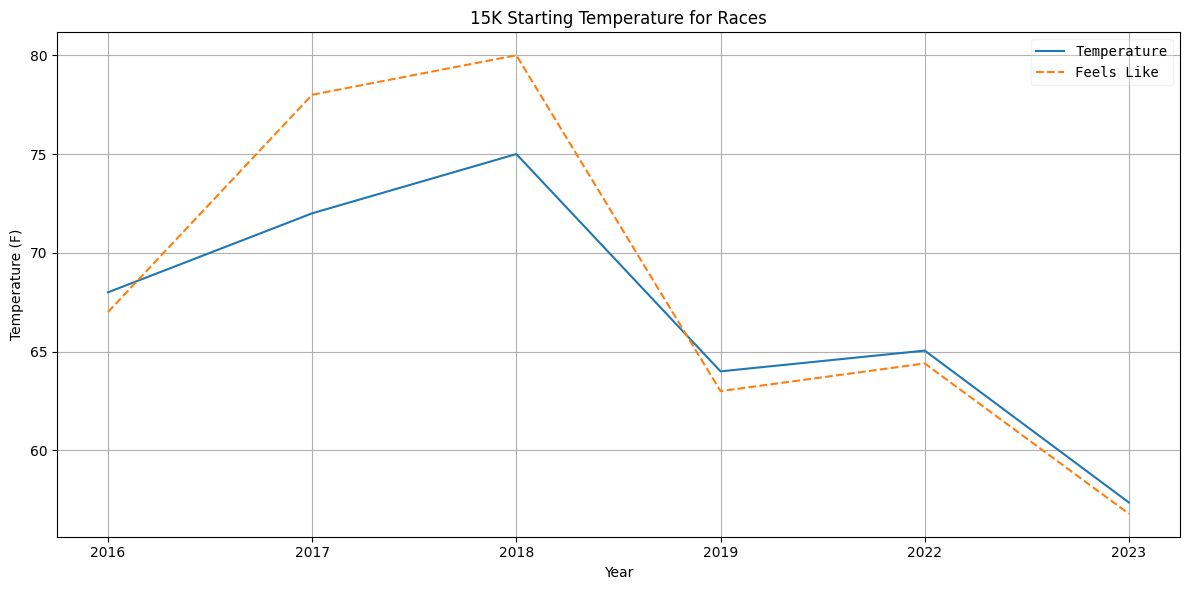

In [36]:
df = df_weather[df_weather.index.isin(year_list)]
x = df.index

plots = plt.plot(x,df['temperature'], '-',
                 x,df['temperatureApparent'], '--',
                )

plt.legend(plots, (['Temperature','Feels Like']), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' Starting Temperature for Races')
plt.xlabel('Year')
plt.ylabel('Temperature (F)')
plt.grid(True)
plt.tight_layout()
if save_charts:
    plt.savefig(os.path.join(chart_dir, race_dist+'_Starting_Weather.png'), dpi=200)

<a id='number_finishers'></a>
## Number of Finishers

### Number of finishers in age groups

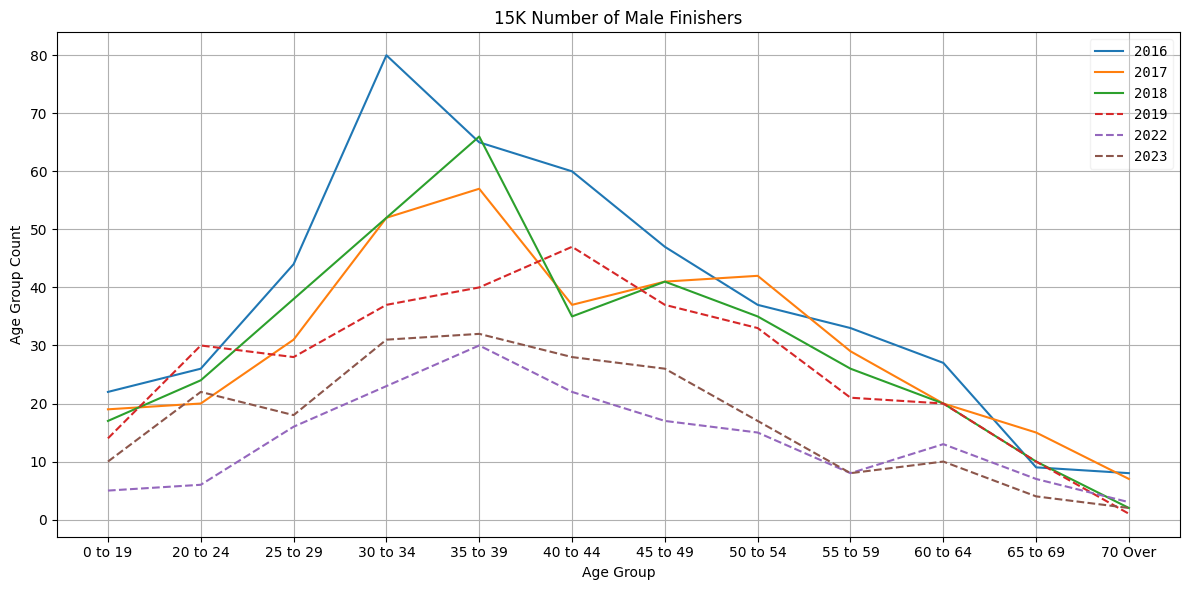

In [37]:
x = age_grp_men['age_group'].unique()
graph_field = 'finisher_count'

plot_lines = get_line_graph_plot_for_years(year_list, x, age_grp_men, graph_field)
plots = plt.plot(*plot_lines)

plt.legend(plots, (year_list), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' Number of Male Finishers')
plt.xlabel('Age Group')
plt.ylabel('Age Group Count')
plt.grid(True)
plt.tight_layout()
# plt.savefig(os.path.join(data_dir, 'Count_male_finishers_5yr_age_goups.svg'))
if save_charts:
    plt.savefig(os.path.join(chart_dir, race_dist+'_Count_male_finishers_5yr_age_goups.png'), dpi=200)

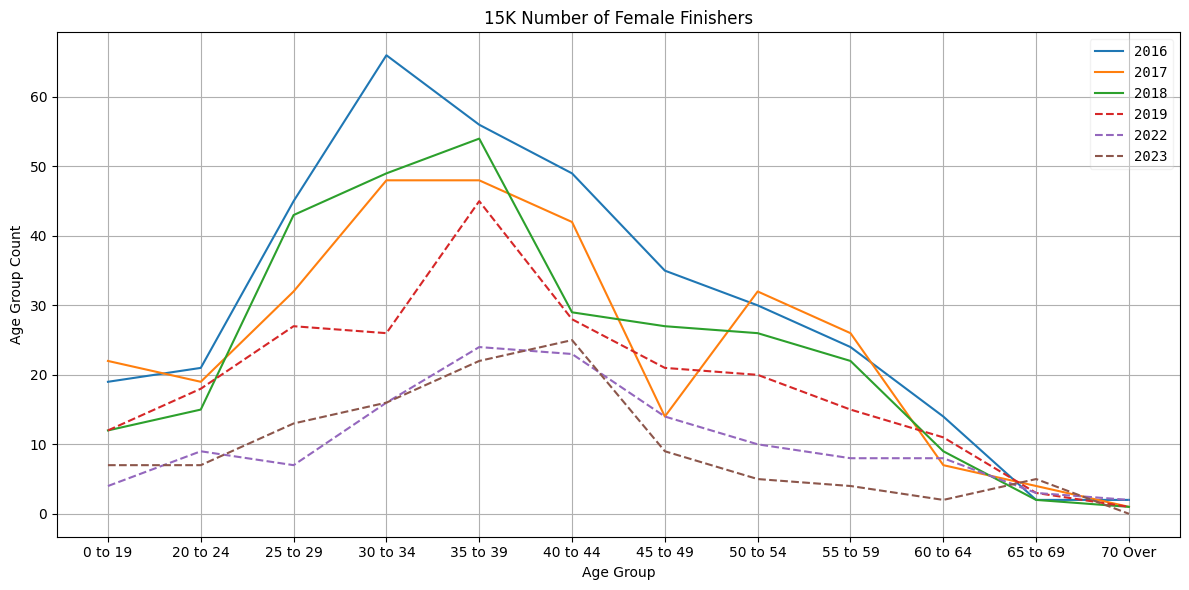

In [38]:
x = age_grp_women['age_group'].unique()
graph_field = 'finisher_count'

plot_lines = get_line_graph_plot_for_years(year_list, x, age_grp_women, graph_field)
plots = plt.plot(*plot_lines)

plt.legend(plots, (year_list), loc='best', 
           framealpha=0.25, prop={'size':'medium', 'family':'monospace'})
plt.gcf().set_size_inches(12,6)
plt.title(race_dist+' Number of Female Finishers')
plt.xlabel('Age Group')
plt.ylabel('Age Group Count')
plt.grid(True)
plt.tight_layout()
if save_charts:
    plt.savefig(os.path.join(chart_dir, race_dist+'_Count_female_finishers_5yr_age_goups.png'), dpi=200)

### Total number of male and female finishers by year

In [39]:
gender_ct = race_results.groupby(['year','gender']).agg(finisher_count=('age', 'count'))\
    .unstack(fill_value=0).stack().reset_index()

In [40]:
display(gender_ct)

,year,gender,finisher_count
0,2016,F,363
1,2016,M,458
2,2017,F,295
3,2017,M,370
4,2018,F,289
5,2018,M,366
6,2019,F,227
7,2019,M,318
8,2022,F,128
9,2022,M,165


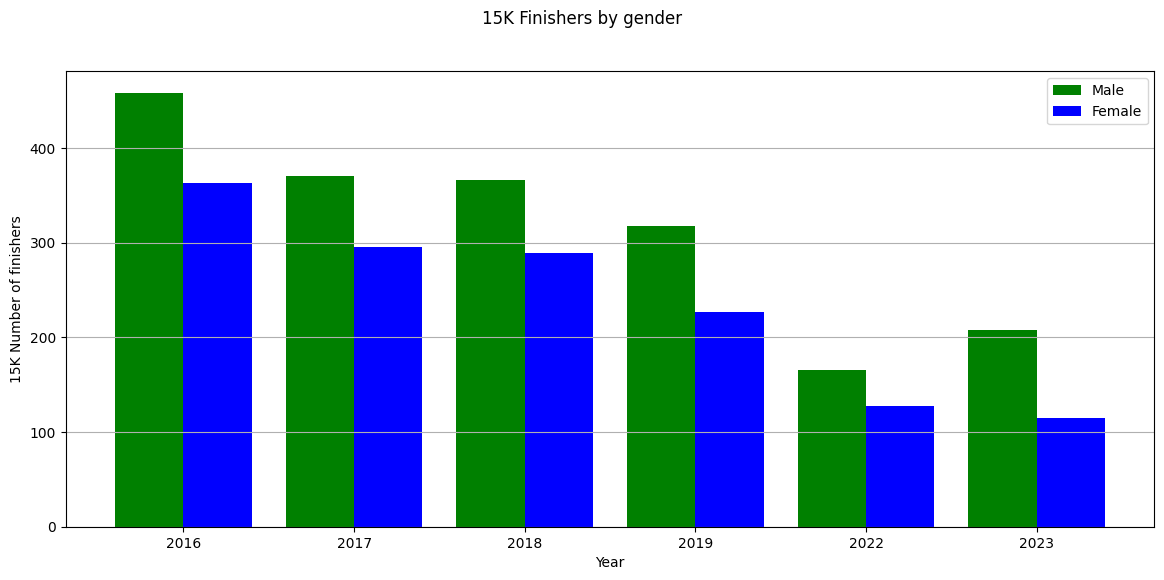

In [41]:
labels = gender_ct['year'].unique()
men_ct_data = gender_ct[gender_ct['gender']=='M']['finisher_count']
women_ct_data = gender_ct[gender_ct['gender']=='F']['finisher_count']

fig, ax = plt.subplots(figsize=(12,6))
bar_width=0.4
xlocs = np.arange(len(labels))

ax.bar(xlocs -bar_width*0.5, men_ct_data, bar_width, color='green', label='Male')
ax.bar(xlocs +bar_width*0.5, women_ct_data, bar_width, color='blue', label='Female')

ax.set_yticks(range(0, gender_ct['finisher_count'].max()+10, 100))
    
ax.set_xticks(ticks=range(len(men_ct_data)))
ax.set_xticklabels(labels)
ax.yaxis.grid(True)
ax.legend(loc='best')
ax.set_ylabel(race_dist+' Number of finishers')
ax.set_xlabel('Year')
fig.suptitle(race_dist+' Finishers by gender')
fig.tight_layout(pad=2)
if save_charts:
    fig.savefig(os.path.join(chart_dir, race_dist+'_Finisher_count_by_gender.png'), dpi=200)
